In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
import scipy.integrate as integrate

FWHM Berechnung der Breite als 'full width at half maximum' einer
Funktion func innerhalb des Intervals lims. 
Die Funktion ist mit einer Gauss-artigen Funktion im Hinterkopf
geschrieben (ein Max. und zu den Seiten abfallend). Für andere
Funktionen (z.B. Sinus) macht der FHWM-Wert nicht unbedingt Sinn. 
 
#### Argumente: 
* func: Vektorisierte Funktion-Handle einer Variablen
* lims: Vektor mit Intervallgrenzen, innerhalb derer die Berechnun läuft
* N: Anzahl der Punkte, die abgetastet werden. 
#### Rückgabe: 
* fwhm: 'full width at half maximum'
* x1: linke Grenze des FWHM-Bereichs
* x2: rechte Grenze des FWHM-Bereichs
* maxVal: Maximum der Funktion

In [2]:
def berechneFWHM(func, lims, N=1000):
    xx = np.linspace(lims[0],lims[1],N)
    funcVals = abs(func(xx))
    maxVal = max(funcVals)
    mask = funcVals > maxVal/2
    x1 = min(xx[mask])
    x2 = max(xx[mask])
    fwhm = x2-x1

    return fwhm, x1, x2, maxVal


GAUSSQUADRATISCHEPHASE: konstruiert einen Gauss-Puls mit quadratischer Phase im Frequenzbereich
#### Argumente: 
* sigma: Breite des Gauss-Pulses
* wp: Mittelwert des Gauss-Pulses
* gdd: group delay dispersion, d.h. Koeffizient des quadratischen Phase
#### Rückgabewerte
* EwFunc: Gauss-Puls im Frequenzbereich, Funktion einer Variablen
* EtFunc: Gauss-Puls im Zeitbereich, Funktion einer Variablen

In [3]:
def gaussQuadratischePhase(sigma, wp, gdd):
    # Frequenzbereich
    #def EwFunc(w):
    #    return math.exp(-(w-wp)^2 / (2*sigma^2) + 1j *gdd/2 * (w-wp)^2)

    EwFunc = lambda w: np.exp(-np.square(w-wp) / (2*np.power(sigma,2)) + 1j *gdd/2 * np.square(w-wp))

    # Zeitbereich    
    def Et(t):
        K = 1 + np.power(gdd,2)*np.power(sigma,4)
        amp = sigma * np.power((4*np.power(np.pi,2)*K),(-1/4)) * np.exp(- np.square(sigma) * np.square(t) / (2*K))
        arg = 1/2 * np.arctan(gdd*np.square(sigma)) + wp*t - 1/2 * gdd * np.power(sigma,4) * np.square(t) / K
        return amp * np.exp(1j * arg)

    EtFunc = lambda t: Et(t)

    return EwFunc, EtFunc

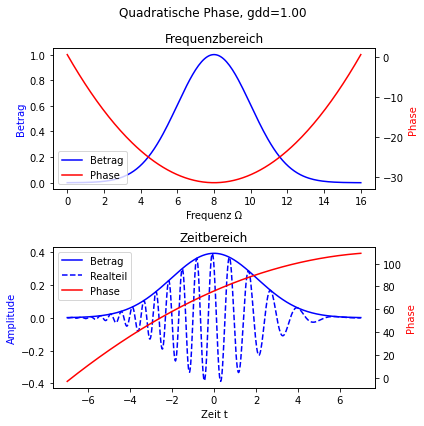

In [4]:
# Darstellung im Zeit- und Frequenzbereich
sigma = 2   # Breite des Gauss-Pulses im Frequenzbereich (half of maximum)
wp = 8      # Trägerfrequenz (Peak im Frequenzbereich) des Gauss-Pulses
gdd = 1     # = c in Gleichung (12) in [1]
EwFunc, EtFunc = gaussQuadratischePhase(sigma, wp, gdd)

ww = np.linspace(0,16,200)
tt = np.linspace(-7,7,500)

fig = plt.figure(figsize=[6,6], layout='tight')
fig.suptitle('Quadratische Phase, gdd=%.2f' %gdd)
ax = fig.add_subplot(2,1,1)
ax2 = ax.twinx()
lns1 = ax.plot(ww,abs(EwFunc(ww)),'b',label='Betrag')
ax.set_ylabel('Betrag', color='b')
ax.set_xlabel('Frequenz \u03A9')
lns2 = ax2.plot(ww, np.unwrap(np.angle(EwFunc(ww))), 'r',label='Phase')
ax2.set_ylabel('Phase', color='r')
plt.title('Frequenzbereich')
lns= lns1+lns2
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc=3)

ax=fig.add_subplot(2,1,2)
ax2 = ax.twinx()
lns1 = ax.plot(tt,abs(EtFunc(tt)),'b',label='Betrag')
ax.set_ylabel('Amplitude', color='b')
lns2 = ax.plot(tt, np.real(EtFunc(tt)),'b--',label='Realteil')
ax.set_xlabel('Zeit t')
lns3 = ax2.plot(tt, np.unwrap(np.angle(EtFunc(tt))), 'r',label='Phase')
ax2.set_ylabel('Phase', color='r')
plt.title('Zeitbereich')
lns= lns1+lns2+lns3
labs = [l.get_label() for l in lns]
ax.legend(lns,labs,loc=2)




Text(0.5, 1.0, 'Full width at half maximum (FHWM)\n FWHM = 4.85, SHG =0.06')

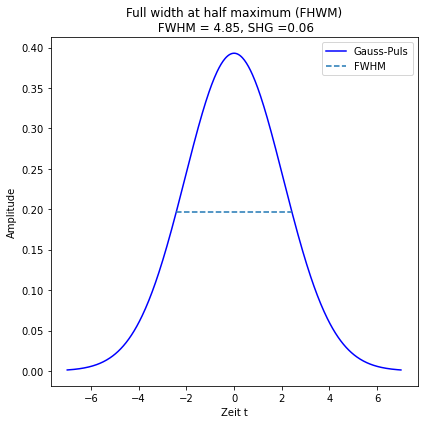

In [5]:
# Breite und Belohnungsfunktion (shg) in Abhängigkeit von gdd

sigma = 2;    # Pulsbreite im Frequenzbereich
wp = 8;       # Trägerfrequenz
gdd = 1;      # hiermit mal rumspielen!

_, EtFunc = gaussQuadratischePhase(sigma, wp, gdd)

fig = plt.figure(figsize=[6,6], layout='tight')
plt.plot(tt,abs(EtFunc(tt)),'b',label='Gauss-Puls')
plt.ylabel('Amplitude')
plt.xlabel('Zeit t')

fhwm, x1, x2, maxVal = berechneFWHM(EtFunc,[1.5*tt[0], 1.5*tt[-1]], 5000)

# Merit-Function: Gleichung (16) in [1]
# Dieser Wert bestimmt die Intensität des SHG-Signals, das experimentell
# gemessen wird (SHG = econd Harmonic Generation). 
# Siehe Abschnitt 6.1.4 in [2]. Die einfachste Messung ist mit tau = 0 in Gleichung (6.2). 

shg,_ = integrate.quad(lambda t: np.power(abs(EtFunc(t)),4),-np.inf,np.Inf)

plt.plot([x1,x2],[maxVal/2*1,maxVal/2*1],'--',label='FWHM')
plt.legend()
plt.title('Full width at half maximum (FHWM)\n FWHM = %.2f' %fhwm + ', SHG =%.2f' %shg)

Text(0.5, 1.0, 'FHWM und SHG in Abhängigkeit der GDD')

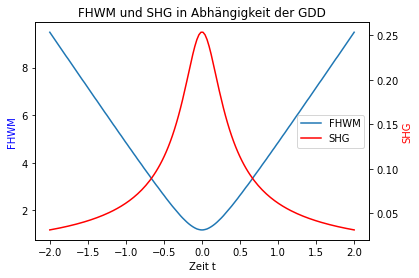

In [6]:
# Breite und SHG in Abhängigkeit von gdd

# Man erkennt, dass die geringste Pulsbreite (minimaler FHWM-Wert) durch
# Maximierung des SHG-Signal erreicht wird.


gddVec = np.linspace(-2,2,150)
#gddVec = gddVec.astype('float32')
fhwmVec = np.zeros(len(gddVec))
shgVec = np.zeros(len(gddVec))

for kk in range(len(gddVec)):
    _,EtFunc = gaussQuadratischePhase(sigma, wp, gddVec[kk])
    fhwmVec[kk],_,_,_ = berechneFWHM(EtFunc,[1.5*tt[0], 1.5*tt[-1]],5000)
    shgVec[kk],_ = integrate.quad(lambda t: np.power(abs(EtFunc(t)),4),-np.inf,np.Inf)

lns1 = plt.plot(gddVec, fhwmVec, label='FHWM')
plt.ylabel('FHWM',color='b')
plt.xlabel('gdd')
ax2 = plt.twinx()
lns2 = ax2.plot(gddVec,shgVec,color='r', label='SHG')
ax2.set_ylabel('SHG',color='r')
lns= lns1+lns2
labs = [l.get_label() for l in lns]
plt.legend(lns,labs,loc=5)
plt.title('FHWM und SHG in Abhängigkeit der GDD')

0.2536092603711677